# Notebook to make figures for conferences and manuscripts

Rainey Aberle

2022

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rxr
import contextily as cx
import geopandas as gpd
import pandas as pd
from skimage.measure import find_contours
import ee
import sys
from shapely.geometry import Point, LineString
import rasterio as rio
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LightSource
import matplotlib
import glob
import wxee as wx
import geemap
import matplotlib
import pickle
from scipy.signal import medfilt
import os

# path to snow-cover-mapping
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

# determine whether to save output figures
save_figures = 1

# path for saving output figures
out_path = base_path+'figures/'

# add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils_PlanetScope as pf

In [2]:
# Authenticate GEE
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

## Snow cover products comparison

In [ ]:
# # -----Load Landsat fSCA
# LS_fn = base_path+'../study-sites/Wolverine/imagery/Landsat/fSCA/LC08_AK_016008_20210829_20210913_02_SNOW/LC08_AK_016008_20210829_20210913_02_VIEWABLE_SNOW_UTM.TIF'
# LS = rxr.open_rasterio(LS_fn)
# # remove no-data values
# LS = LS.where(LS != -9999)
# # account for image multiplier
# LS_scalar = 0.001
# LS = LS * LS_scalar
# crs = LS.rio.crs.to_string()

# # -----Load MODIS fSCA
# M_fn = base_path+'../study-sites/Wolverine/imagery/MODIS/Terra_fSCA/2021_08_15.tif'
# M = rxr.open_rasterio(M_fn)
# # grab snow cover band
# M_fSCA = M.isel(band=0)
# # remove no data values
# M_fSCA = M_fSCA.where(M_fSCA != -3.2768e04)
# # reproject 
# M_fSCA= M_fSCA.rio.reproject(crs)

# # -----Load PlanetScope image and snow
# # RGB image
# PS_path = base_path+'../study-sites/Wolverine/imagery/PlanetScope/adjusted-filtered/'
# PS_fn = '20210815_20_adj.tif'
# PS = rxr.open_rasterio(PS_path + PS_fn)
# PS = PS / 1e4
# # classify image
# clf_fn = base_path+'/inputs-outputs/PS_classifier_all_sites.sav'
# clf = pickle.load(open(clf_fn, 'rb'))
# feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
# feature_cols = pickle.load(open(feature_cols_fn,'rb'))
# sys.path.insert(1, base_path+'functions/')
# from ps_pipeline_utils import classify_image
# im_classified_fn, im = classify_image(PS_fn, PS_path, clf, feature_cols, False, None, out_path)
# # load classified image
# im_classified = rxr.open_rasterio(out_path + im_classified_fn) 

In [ ]:
# # -----Create snow colormap
# color_snow = '#4eb3d3'
# color_no_snow = 'w'
# # create colormap
# colors = [color_no_snow, color_snow]
# cmp = cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# # -----Plot
# fig, ax = plt.subplots(2, 2, figsize=(10,10))
# ax = ax.flatten()
# plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
# xmin, xmax, ymin, ymax = 391, 399, 6694, 6702
# # MODIS
# M_im = ax[0].imshow(M_fSCA.data, cmap=cmp, clim=(0,100),
#                     extent=(np.min(M_fSCA.x.data)/1000, np.max(M_fSCA.x.data)/1000, 
#                             np.min(M_fSCA.y.data)/1000, np.max(M_fSCA.y.data)/1000))
# ax[0].set_xticks(np.linspace(392, 398, num=4))
# ax[0].set_yticks(np.linspace(6694, 6702, num=5))
# ax[0].set_xticklabels([])
# ax[0].set_xlim(xmin, xmax)
# ax[0].set_ylim(ymin, ymax)
# ax[0].set_ylabel('Northing [km]')
# ax[0].set_title('a) MODIS f$_{SCA}$')
# # LS
# LS_im = ax[1].imshow(LS_fSCA, cmap=cmp, clim=(0,1),
#                    extent=(np.min(LS_x)/1000, np.max(LS_x)/1000, np.min(LS_y)/1000, np.max(LS_y)/1000))
# ax[1].set_xticks(np.linspace(392, 398, num=4))
# ax[1].set_yticks(np.linspace(6694, 6702, num=5))
# ax[1].set_xticklabels([])
# ax[1].set_yticklabels([])
# ax[1].set_xlim(xmin, xmax)
# ax[1].set_ylim(ymin, ymax)
# ax[1].set_title('b) Landsat 8 f$_{SCA}$')
# # PS RGB
# ax[2].imshow(np.dstack([PS.data[2], PS.data[1], PS.data[0]]),
#            extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
# ax[2].set_xticks(np.linspace(392, 398, num=4))
# ax[2].set_yticks(np.linspace(6694, 6702, num=5))
# ax[2].set_xlim(xmin, xmax)
# ax[2].set_ylim(ymin, ymax)
# ax[2].set_ylabel('Northing [km]')
# ax[2].set_xlabel('Easting [km]')
# ax[2].set_title('c) PlanetScope RGB')
# # PS snow
# im_classified = im_classified.where(im_classified!=-9999)
# im_binary = xr.where(im_classified<=2, 1, 0)
# PS_snow_im = ax[3].imshow(im_binary.data[0], cmap=cmp, clim=(0,1),
#                    extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
# ax[3].set_xticks(np.linspace(392, 398, num=4))
# ax[3].set_yticks(np.linspace(6694, 6702, num=5))
# ax[3].set_yticklabels([])
# ax[3].set_xlim(xmin, xmax)
# ax[3].set_ylim(ymin, ymax)
# ax[3].set_xlabel('Easting [km]')
# ax[3].set_title('d) PlanetScope SCA')
# # colorbar
# cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
# fig.colorbar(M_im, cax=cbar_ax)
# plt.show()

# if save_figures:
#     fig.savefig(out_path+'comparing_SCA_products.png', dpi=300, facecolor='white', edgecolor='none')
#     print('figure saved to file')

## Study sites

Warning 1: TIFFFetchNormalTag:Incorrect value for "RichTIFFIPTC"; tag ignored


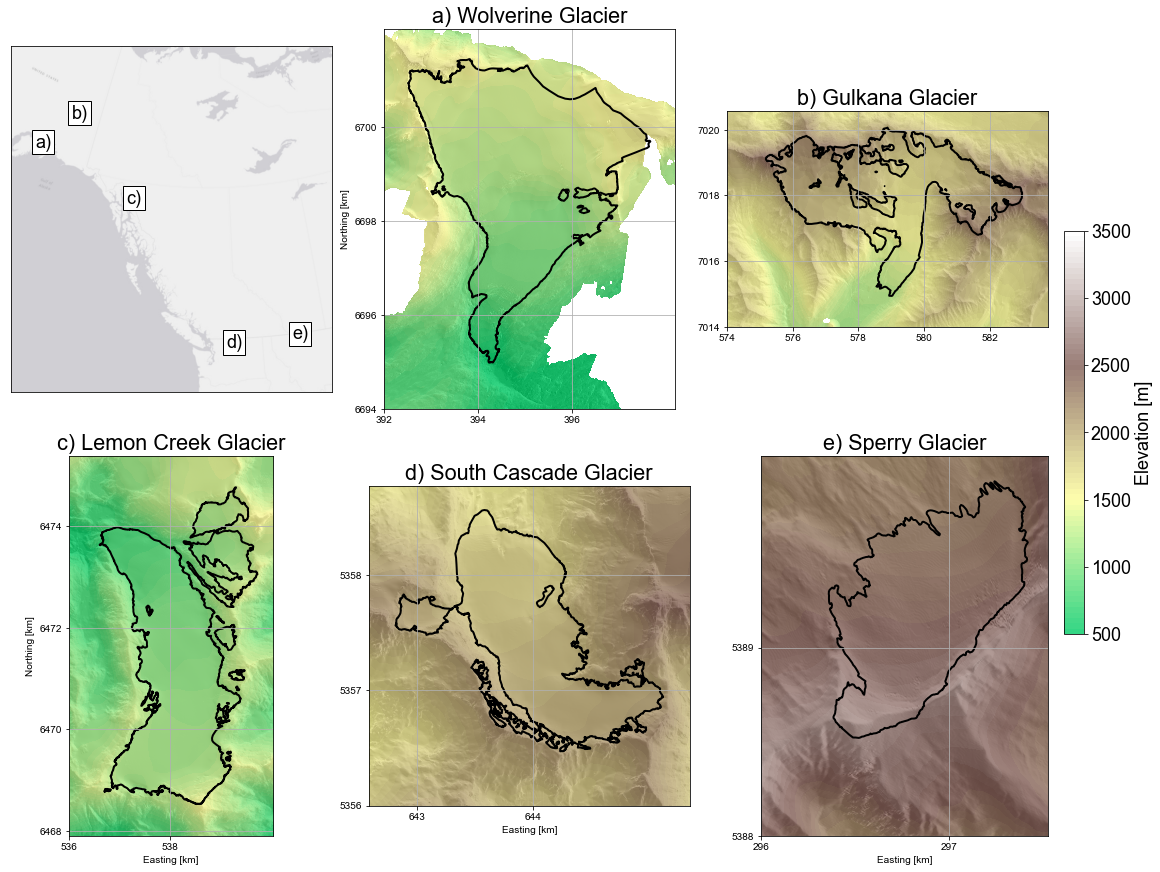

figure saved to file


In [23]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']
site_names_display = ['Wolverine', 'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
site_colors = ['#1f78b4', '#33a02c', '#fec44f', '#cc4c02', '#984ea3']
text_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# define colormap for elevations
cmap_elev = plt.cm.terrain(np.linspace(0, 1, 100))
cmap_elev = ListedColormap(cmap_elev[25:, :])

# -----Set up figure
fig, ax = plt.subplots(2, 3, figsize=(16, 12), layout='constrained')
plt.rcParams.update({'font.size':18, 'font.sans-serif':'Arial'})
ax = ax.flatten()
# -----Loop through sites
i=0
epsg_A = 32610
for site_name, site_color, site_name_display, text_label in list(zip(site_names, site_colors, site_names_display, text_labels)):
    ### AOI
    # load file
    AOI_fn = glob.glob(base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp')[0]
    AOI = gpd.read_file(AOI_fn)
    AOI_WGS = AOI.to_crs(4326)
    # solve for optimal UTM zone
    AOI_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = pf.convert_wgs_to_utm(AOI_centroid[0], AOI_centroid[1])
    # reproject
    AOI_UTM = AOI_WGS.to_crs(epsg_UTM)
    AOI_A = AOI.to_crs(epsg_A)
    ### DEM
    DEM_fn = glob.glob(base_path + '../study-sites/' + site_name + '/DEMs/' + site_name + '*_DEM*.tif')[0]
    DEM = xr.open_dataset(DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject 
    # DEM = DEM.rio.reproject(str('EPSG:'+epsg_UTM))
    ### Plot
    # A) Study sites map
    ax[0].plot(AOI_A.geometry[0].centroid.xy[0][0], AOI_A.geometry[0].centroid.xy[1][0], 
            '.', markerfacecolor=site_color, markeredgecolor='k', markersize=5)
    ax[0].text(AOI_A.geometry[0].centroid.xy[0][0], AOI_A.geometry[0].centroid.xy[1][0],
               text_labels[i], bbox=dict(facecolor='white', edgecolor='black', pad=3))
    # Individual glacier plot
    AOI_UTM.plot(ax=ax[i+1], edgecolor='k', facecolor='none', linewidth=2)
    ls = LightSource(azdeg=315, altdeg=45) # shade from the northwest, with the sun 45 degrees from horizontal
    x, y = DEM.x.data, DEM.y.data
    dx, dy = x[1]-x[0], y[1]-y[0]
    ax[i+1].imshow(ls.hillshade(DEM.elevation.data[0], vert_exag=1, dx=dx, dy=dy), cmap='Greys', extent=(x[0], x[-1], y[-1], y[0]))
    DEM_im = ax[i+1].imshow(DEM.elevation.data[0], cmap=cmap_elev, clim=(500, 3500), alpha=0.8, extent=(x[0], x[-1], y[-1], y[0]))
    if AOI.geometry[0].geom_type=='MultiPolygon':
        xmin_AOI = np.min([np.min(geom.exterior.coords.xy[0]) for geom in AOI.geometry[0].geoms])
        xmax_AOI = np.max([np.max(geom.exterior.coords.xy[0]) for geom in AOI.geometry[0].geoms])
        ymin_AOI = np.min([np.min(geom.exterior.coords.xy[1]) for geom in AOI.geometry[0].geoms])
        ymax_AOI = np.max([np.max(geom.exterior.coords.xy[1]) for geom in AOI.geometry[0].geoms])      
    else:
        xmin_AOI = np.min(AOI.geometry[0].exterior.coords.xy[0])
        xmax_AOI = np.max(AOI.geometry[0].exterior.coords.xy[0])
        ymin_AOI = np.min(AOI.geometry[0].exterior.coords.xy[1])
        ymax_AOI = np.max(AOI.geometry[0].exterior.coords.xy[1])  
    xmin = xmin_AOI - 0.1*(xmax_AOI - xmin_AOI)
    xmax = xmax_AOI + 0.1*(xmax_AOI - xmin_AOI)
    ymin = ymin_AOI - 0.1*(ymax_AOI - ymin_AOI)
    ymax = ymax_AOI + 0.1*(ymax_AOI - ymin_AOI) 
    # change x and y tick labels to km
    ax[i+1].set_xlim(xmin, xmax)
    ax[i+1].set_ylim(ymin, ymax)
    if i < 3:
        ax[i+1].set_xticks(np.arange(np.round(xmin,-3), np.round(xmax,-3), 2e3))
        ax[i+1].set_yticks(np.arange(np.round(ymin,-3), np.round(ymax,-3), 2e3)) 
    else:
        ax[i+1].set_xticks(np.arange(np.round(xmin,-3), np.round(xmax,-3), 1e3))
        ax[i+1].set_yticks(np.arange(np.round(ymin,-3), np.round(ymax,-3), 1e3)) 
    ax[i+1].set_xticklabels([str(int(x/1e3)) for x in ax[i+1].get_xticks()])
    ax[i+1].set_yticklabels([str(int(y/1e3)) for y in ax[i+1].get_yticks()])
    ax[i+1].set_title(text_label + ' ' + site_name_display + ' Glacier')
    ax[i+1].grid()
    # add axes labels
    if (i==1) or (i==3):
        ax[i].set_ylabel('Northing [km]')
    if i > 1:
        ax[i+1].set_xlabel('Easting [km]')
    
    # increase loop counter
    i+=1

# A: study sites map
ax[0].set_xlim(-1100000, 1500000)
ax[0].set_ylim(5000000, 7800000)
ax[0].set_xticks([])
ax[0].set_yticks([])
cx.add_basemap(ax[0], crs='EPSG:'+str(epsg_A), source=cx.providers.Esri.WorldGrayCanvas, attribution=False)
fig.colorbar(DEM_im, ax=[ax[2], ax[5]], shrink=0.5, label='Elevation [m]')
plt.show()

if save_figures:
    fig.savefig(out_path+'study_sites.png', dpi=300, facecolor='white', edgecolor='none')
    print('figure saved to file')

## Methods workflow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


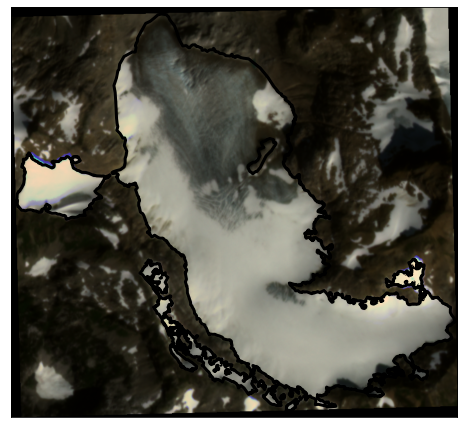

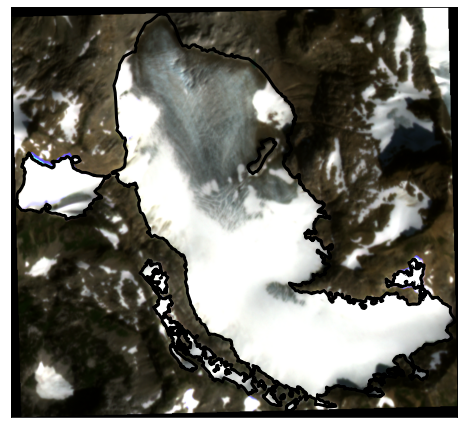

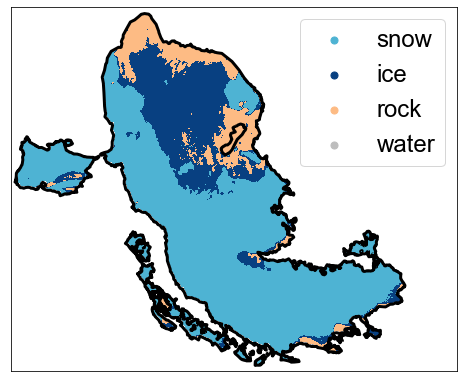

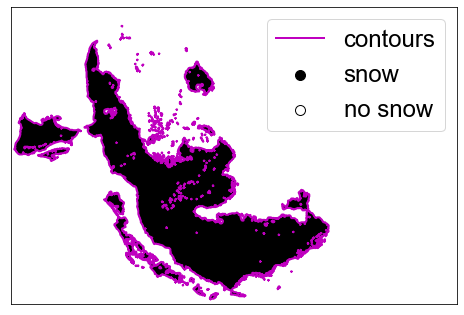

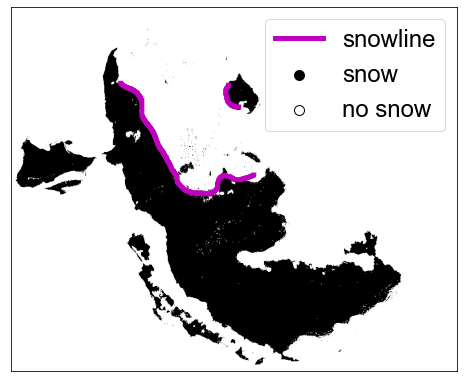

figures saved to file


In [27]:
font_size = 24

# -----Image settings
# image date
im_date = '20220828'
# image band scalar multiplier
im_scalar = 1e4
# site name
site_name = 'SouthCascade'
# USGS glacier outline
AOI_fn = glob.glob(base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp')[0]
AOI = gpd.read_file(AOI_fn)
# define colors for classified image
color_snow = '#4eb3d3'
color_ice = '#084081'
color_rock = '#fdbb84'
color_water = '#bdbdbd'
# create colormap
colors = [color_snow, color_snow, color_ice, color_rock, color_water]
cmp = ListedColormap(colors)

# -----1. Raw image
im_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/mosaics/'
im_fn = glob.glob(im_path + im_date + '*.tif')[0]
im = rxr.open_rasterio(im_fn)
im = im / im_scalar
xmin, xmax, ymin, ymax = np.min(im.x.data), np.max(im.x.data), np.min(im.y.data), np.max(im.y.data)
# plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.imshow(np.dstack([im.data[2], im.data[1], im.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=3)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.set_xticks([])
ax1.set_yticks([])

# -----2. Adjusted image
im_adj_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/adjusted/'
im_adj_fn = glob.glob(im_adj_path+im_date+'*_adj.tif')[0]
im_adj = rxr.open_rasterio(im_adj_fn)
im_adj = im_adj / im_scalar
# plot
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.imshow(np.dstack([im_adj.data[2], im_adj.data[1], im_adj.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI.plot(ax=ax2, facecolor='none', edgecolor='k', linewidth=3)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks([])
ax2.set_yticks([])

# -----3. Classified image
im_classified_path = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/classified/'
im_classified_fn = glob.glob(im_classified_path+im_date+'*_classified.tif')[0]
im_classified = rxr.open_rasterio(im_classified_fn)
im_classified = im_classified.where(im_classified!=-9999) # remove no data values
# plot
fig3, ax3 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
ax3.imshow(im_classified.data[0], cmap=cmp, vmin=1, vmax=5,
           extent=(xmin, xmax, ymin, ymax))
AOI.plot(ax=ax3, facecolor='none', edgecolor='k', linewidth=3)
# plot dummy points for legend
ax3.scatter(0, 0, color=color_snow, s=50, label='snow')
ax3.scatter(0, 0, color=color_ice, s=50, label='ice')
ax3.scatter(0, 0, color=color_rock, s=50, label='rock')
ax3.scatter(0, 0, color=color_water, s=50, label='water')
ax3.set_xlim(xmin, xmax+300)
ax3.set_ylim(ymin, ymax)
ax3.legend(loc='upper right')
ax3.set_xticks([])
ax3.set_yticks([])

# -----4. Image contours
# create binary snow matrix
im_binary = xr.where(im_classified[0] <=2, 1, 0).data
# Find contours at a constant value of 0.5 (between 0 and 1)
contours = find_contours(im_binary, 0.5)
# convert contour points to image coordinates
contours_coords = []
for contour in contours: 
    ix = np.round(contour[:,1]).astype(int)
    iy = np.round(contour[:,0]).astype(int)
    coords = (im_adj.isel(x=ix, y=iy).x.data, # image x coordinates
              im_adj.isel(x=ix, y=iy).y.data) # image y coordinates
    # zip points together
    xy = list(zip([x for x in coords[0]], 
                  [y for y in coords[1]]))
    contours_coords = contours_coords + [xy]
# plot
fig4, ax4 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
binary_plt = ax4.imshow(im_binary, cmap='Greys')
for i, contour in list(zip(np.arange(0,len(contours)), contours)):
    if i==0:
        plt.plot(contour[:,1], contour[:,0], '-m', label='contours', linewidth=2)
    else:
        plt.plot(contour[:,1], contour[:,0], '-m', label='_nolegend', linewidth=2)
# plot dummy points for legend
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax4.set_xlim(0,len(im.x.data)+300)
ax4.set_ylim(len(im.y.data), 0)
ax4.legend(loc='upper right')
ax4.set_xticks([])
ax4.set_yticks([])

# -----5. Snow line
snowlines_fn = base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/snowlines/SouthCascade_20160819_20220927_snowlines.pkl'
snowlines = pd.read_pickle(snowlines_fn)
snowline = snowlines['snowlines_coords'].iloc[-15]
# plot
fig5, ax5 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
binary_plt = ax5.imshow(im_binary, 
                        extent=(xmin, xmax, ymin, ymax),
                        cmap='Greys')
for i, sl in enumerate(snowline):
    if i==0:
        ax5.plot(*sl.coords.xy, '-m', label='snowline', linewidth=5)
    else:
        ax5.plot(*sl.coords.xy, '-m', label='_nolegend', linewidth=5)
# plot dummy points for legend
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax5.set_xlim(xmin, xmax+300)
ax5.set_ylim(ymin, ymax)
ax5.legend(loc='upper right')
ax5.set_xticks([])
ax5.set_yticks([])
plt.show()

if save_figures:
    fig1.savefig(out_path+'processing_workflow_1.png', dpi=300, facecolor='white', edgecolor='none')
    fig2.savefig(out_path+'processing_workflow_2.png', dpi=300, facecolor='white', edgecolor='none')
    fig3.savefig(out_path+'processing_workflow_3.png', dpi=300, facecolor='white', edgecolor='none')
    fig4.savefig(out_path+'processing_workflow_4.png', dpi=300, facecolor='white', edgecolor='none')
    fig5.savefig(out_path+'processing_workflow_5.png', dpi=300, facecolor='white', edgecolor='none')
    print('figures saved to file')

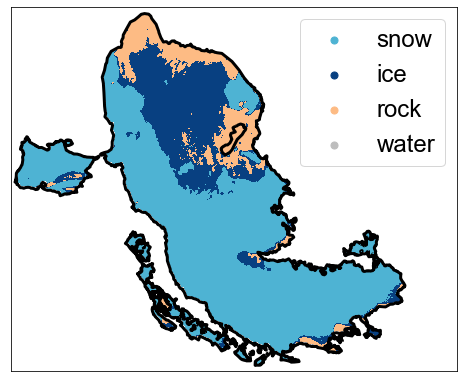

In [25]:
ax3.set_xlim(xmin, xmax+300)
ax3.legend(loc='upper right')
fig3

## Median snow line elevations

In [ ]:
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']
site_names_display = ['Wolverine',  'Gulkana', 'Lemon Creek', 'South Cascade', 'Sperry']
dataset_colors = {'Landsat': '#33a02c',
                  'Sentinel2': '#1f78b4',
                  'PlanetScope': '#a6cee3'
                 }
text_labels = ['a)', 'b)', 'c)', 'd)', 'e)']

# set up figure
fig, ax = plt.subplots(5, 1, figsize=(20, 24))
ax = ax.flatten()
plt.rcParams.update({'font.size':28, 'font.sans-serif':'Arial'})
# minor ticks every month.
fmt_month = matplotlib.dates.MonthLocator(bymonth=(5, 11))
# minor ticks every year.
fmt_year = matplotlib.dates.YearLocator()

# -----Loop through sites
for site_name, site_name_display, text_label, i in list(zip(site_names, site_names_display, text_labels, np.arange(0,len(site_names)))):
    
    # -----Estimated snow lines             
    # PlanetScope
    PS_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + '/imagery/PlanetScope/snowlines/' 
                               + site_name + '*snowlines.pkl')[0]
    PS_sl_est = pd.read_pickle(PS_sl_est_path)
    PS_sl_est['year'] = [x.year for x in PS_sl_est['datetime']]
    ax[i].plot(PS_sl_est['datetime'], PS_sl_est['snowlines_elevs_median'], '.',
               markeredgecolor='w', markerfacecolor=dataset_colors['PlanetScope'], 
               markersize=20, markeredgewidth=1, label='_nolegend_')
    # Sentinel-2
    S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + '/imagery/Sentinel-2/' 
                               + 'Sentinel2_' + site_name + '*snowlines.pkl')[0]
    S2_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + '/imagery/Sentinel-2/' 
                               + 'Sentinel2_' + site_name + '*snowlines.pkl')[0]
    S2_sl_est = pd.read_pickle(S2_sl_est_path)
    S2_sl_est['year'] = [int(x[0:4]) for x in S2_sl_est['datetime']]
    ax[i].plot(S2_sl_est['datetime'].astype(np.datetime64), S2_sl_est['snowlines_elevs_median'], '*',
               markeredgecolor='w', markerfacecolor=dataset_colors['Sentinel2'], 
               markersize=18, markeredgewidth=1, label='_nolegend_')
    # Landsat
    L_sl_est_path = glob.glob(base_path + '../study-sites/' + site_name + '/imagery/Landsat/' 
                               + 'Landsat_' + site_name + '*snowlines.pkl')[0]
    L_sl_est = pd.read_pickle(L_sl_est_path)
    L_sl_est['year'] = [int(x[0:4]) for x in L_sl_est['datetime']]
    ax[i].plot(L_sl_est['datetime'].astype(np.datetime64), L_sl_est['snowlines_elevs_median'], '^',
               markeredgecolor='w', markerfacecolor=dataset_colors['Landsat'], 
               markersize=12, markeredgewidth=1, label='_nolegend_')
    # concatenate snowlines dataframes
    sl_est_df = pd.concat([PS_sl_est, S2_sl_est, L_sl_est])
    # axis limits
    xmin, xmax = np.datetime64('2016-05-01T00:00:00'), np.datetime64('2022-11-01T00:00:00')
    sl_elev_median_min = np.min(sl_est_df['snowlines_elevs_median'])
    sl_elev_median_max = np.max(sl_est_df['snowlines_elevs_median'])
    ymin = sl_elev_median_min - 0.1*(sl_elev_median_max - sl_elev_median_min)
    ymax = sl_elev_median_max + 0.1*(sl_elev_median_max - sl_elev_median_min)
    ax[i].set_xlim(xmin, xmax)
    ax[i].set_ylim(ymin, ymax)
    ax[i].grid()
    # x-labels
    ax[i].xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
    ax[i].xaxis.set_major_locator(fmt_month)
    ax[i].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
    # create a second x-axis beneath the first x-axis to show the year in YYYY format
    sec_xaxis = ax[i].secondary_xaxis(-0.1)
    sec_xaxis.xaxis.set_major_locator(fmt_year)
    sec_xaxis.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
    # Hide the second x-axis spines and ticks
    sec_xaxis.spines['bottom'].set_visible(False)
    sec_xaxis.tick_params(axis='x', length=0, pad=15)
    if i<5:
        ax[i].set_xticklabels([])
        sec_xaxis.set_xticklabels([])
    # y-label
    if (i==0) or (i==2) or (i==4):
        ax[i].set_ylabel('Elevation [m]')
    # text label
    ax[i].text((xmax-xmin)*0.015 + xmin, (ymax-ymin)*0.87 + ymin, 
               text_label + ' ' + site_name_display, 
               bbox=dict(facecolor='white', edgecolor='black', pad=5))

    # -----Observed snow lines
    # define path to digitized snow lines
    sl_obs_path = base_path + '../snowline-package/' + site_name + '/snowlines/'
    sl_obs_fns = glob.glob(sl_obs_path + '*.shp')
    # load AOI as gpd.GeoDataFrame
    AOI_fn = base_path + '../study-sites/' + site_name + '/glacier_outlines/' + site_name + '_USGS_*.shp'
    AOI_fn = glob.glob(AOI_fn)[0]
    AOI = gpd.read_file(AOI_fn)
    # load DEM from GEE
    DEM, AOI_UTM = pf.query_GEE_for_DEM(AOI)
    # loop through observed snow lines
    for sl_obs_fn in sl_obs_fns:
        # load observed snow line
        sl_obs = gpd.read_file(sl_obs_fn)
        # extract date from filename
        date = sl_obs_fn.split('/'+site_name+'_')[1][0:8]
        datetime = np.datetime64(date[0:4] + '-' + date[4:6] + '-' + date[6:8]
                                 + 'T00:00:00')
        # reproject snow line to UTM
        sl_obs_UTM = sl_obs.to_crs(str(AOI_UTM.crs.to_epsg()))
        # interpolate elevation at snow line points
        if len(sl_obs_UTM) > 1:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[1].xy[0], 
                                                     sl_obs_UTM.geometry[1].xy[1]))])
        else:
            sl_obs_elev = np.array([DEM.sel(time=DEM.time.data[0], x=x, y=y, method='nearest').elevation.data 
                                for x, y in list(zip(sl_obs_UTM.geometry[0].xy[0], 
                                                     sl_obs_UTM.geometry[0].xy[1]))])
        # calculate median snow line elevation
        sl_obs_elev_median = np.nanmedian(sl_obs_elev)
        # plot
        ax[i].plot(datetime, sl_obs_elev_median, 'xk', markersize=10, markeredgewidth=2, label='_nolegend_')
        
    # -----Min and max snowline elevation
    
    # ----Linear trendline
    
# -----Dummy points for legend
# observed
ax[0].plot(np.datetime64('1970-01-01'), 0, 'xk', 
           markersize=15, markeredgewidth=3, label='observed')
# Landsat
ax[0].plot(np.datetime64('1970-01-01'), 0, '^', 
           markeredgecolor=dataset_colors['Landsat'], markerfacecolor=dataset_colors['Landsat'], 
           markersize=12, label='Landsat 8/9')
# Sentinel-2
ax[0].plot(np.datetime64('1970-01-01'), 0, '*',
           markeredgecolor=dataset_colors['Sentinel2'], markerfacecolor=dataset_colors['Sentinel2'], 
           markersize=18, label='Sentinel-2')
# PlanetScope
ax[0].plot(np.datetime64('1970-01-01'), 0, '.', 
       markeredgecolor=dataset_colors['PlanetScope'], markerfacecolor=dataset_colors['PlanetScope'], 
       markersize=20, label='PlanetScope')
ax[0].legend(loc='center', bbox_to_anchor=(0.5, 1.15), ncol=4)
# -----Date label formatting
ax[4].xaxis.set_minor_formatter(matplotlib.dates.DateFormatter('%b'))
ax[4].xaxis.set_major_locator(fmt_month)
ax[4].xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%b'))
# create a second x-axis beneath the first x-axis to show the year in YYYY format
sec_xaxis = ax[4].secondary_xaxis(-0.1)
sec_xaxis.xaxis.set_major_locator(fmt_year)
sec_xaxis.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y'))
# Hide the second x-axis spines and ticks
sec_xaxis.spines['bottom'].set_visible(False)
sec_xaxis.tick_params(length=0, pad=10)
ax[4].set_xlim(np.datetime64('2016-05-01T00:00:00'), np.datetime64('2022-11-01T00:00:00'))
plt.show()
    
# -----Save figure
if save_figures:
    fig_fn = 'median_snowline_elevs.png'
    fig.savefig(out_path + fig_fn, facecolor='w', dpi=300)
    print('figure saved to file')

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
years = np.unique(PS_sl_est['year'])
for year in years[0:2]:
    
    # compile snowlines median elevations from all datasets
    sl_est_all = pd.concat([PS_sl_est.loc[PS_sl_est['year']==year],
                            L_sl_est.loc[L_sl_est['year']==year]])
    sl_est_all = sl_est_all.dropna().reset_index(drop=True)
    # add column for days since 2016-01-01
    sl_est_all['day'] = sl_est_all['datetime'].astype(str)
    # sort by date
    sl_est_all = sl_est_all.sort_values(by='datetime_str')
    # identify maximum snowline elevation
    # sl_est_all_max = sl_est_all['snowlines_elevs_median'].max()
    # # subset snowlines before the maximum elevation is reached
    # Ix = np.where(sl_est_all['snowlines_elevs_median']==sl_est_all_max)[0][0]
    # sl_est_all_subset = sl_est_all.iloc[0:Ix+1]
    # # fit a linear regression model
    # x = np.array(sl_est_all_subset['datetime'], dtype=np.datetime64).reshape(1, -1)[0]
    # y = np.array(sl_est_all_subset['snowlines_elevs_median'])
    # print(x, y)
    # model = LinearRegression().fit(x, y)
    # r_sq = model.score(x, y)
    # print(f"coefficient of determination: {r_sq}")
    

# Training data characteristics by dataset

In [ ]:
# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)

# -----Define band ranges
L8_dict = dataset_dict['Landsat']
L8_dict['bands'] = {'SR_B2': {'name': 'blue',
                              'min_nm': 450,
                              'max_nm': 510},
                    'SR_B3': {'name': 'green',
                              'min_nm': 530,
                              'max_nm': 590},
                    'SR_B4': {'name': 'red',
                              'min_nm': 640,
                              'max_nm': 670},
                    'SR_B5': {'name': 'NIR',
                              'min_nm': 850,
                              'max_nm': 880},
                    'SR_B6': {'name': 'SWIR1',
                              'min_nm': 1570,
                              'max_nm': 1650},
                    'SR_B7': {'name': 'SWIR2',
                              'min_nm': 2110,
                              'max_nm': 2290}
                   }

S2_dict = dataset_dict['Sentinel-2']
S2_dict['bands'] = {'B2': {'name': 'blue',
                           'wavelength_min_nm': 459,
                           'wavelength_max_nm': 525
                          },
                    'B3': {'name': 'green',
                           'wavelength_min_nm': 541,
                           'wavelength_max_nm': 577
                          },
                    'B4': {'name': 'red',
                           'wavelength_min_nm': 649,
                           'wavelength_max_nm': 680
                          },
                    'B8': {'name': 'NIR',
                           'wavelength_min_nm': 780,
                           'wavelength_max_nm': 886
                          },
                    'B11': {'name': 'SWIR1',
                           'wavelength_min_nm': 1567,
                           'wavelength_max_nm': 1658
                            
                          },
                    'B12': {'name': 'SWIR2',
                           'wavelength_min_nm': 2114,
                           'wavelength_max_nm': 2289
                          }
                   }
PS_dict = dataset_dict['PlanetScope']
PS_dict['bands'] = {'B1': {'name': 'blue',
                           'wavelength_min_nm':,
                           'wavelength_max_nm': 
                          }
